Dev notebook
============

In [2]:
import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage
from scipy import signal
from scipy import stats


from domb.reg_type.wf_x2_m2 import WF_2x_2m as WF
from domb.fret.e_app import Eapp
from domb.red_green.wt_vs_mut import WTvsMut as WvM
from domb.utils import plot
from domb.utils.plot import CMaps
from domb.utils import masking

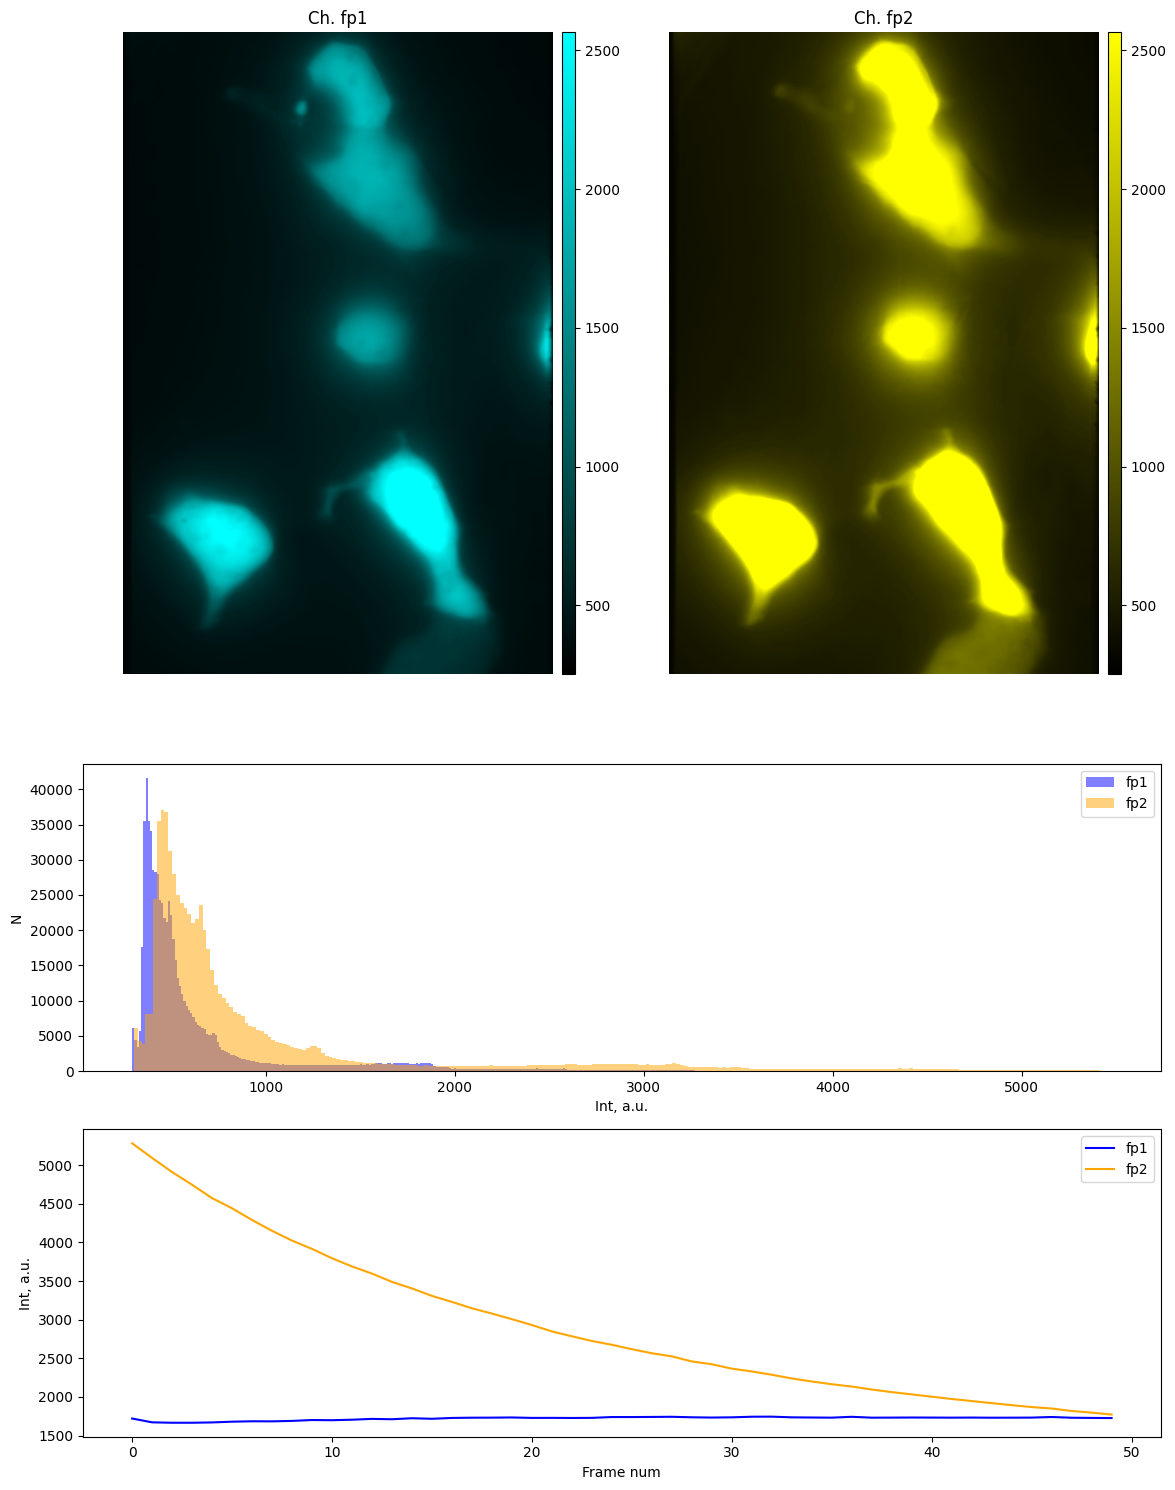

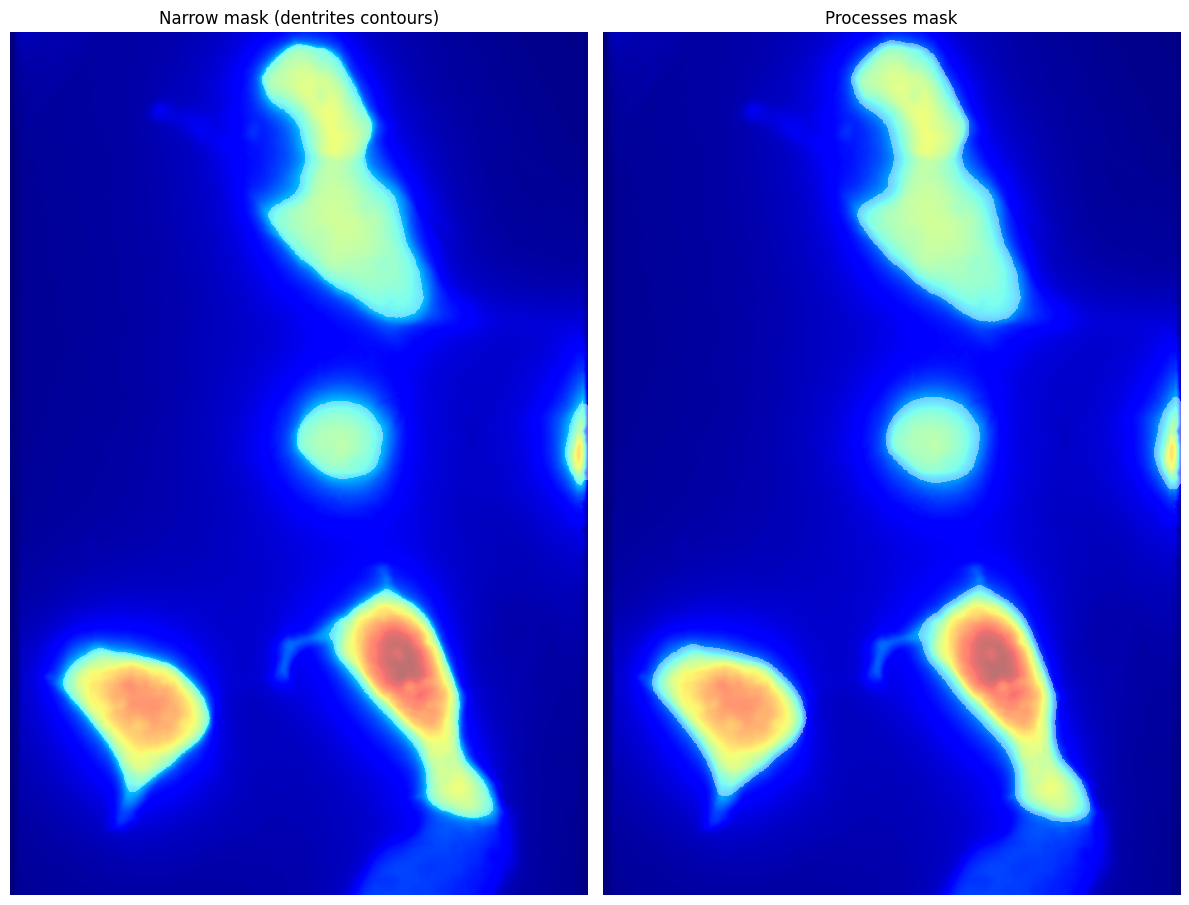

In [3]:
reg_path = 'data/fret_calibration/tandem/03.tif'
# reg_path = 'data/wt_vs_mut/23_06_23_11.tif'
reg_name = reg_path.split('/')[-1]
reg_name = reg_name.split('.')[0]


# fp1 - CFP, fp2 - YFP
reg = WF(img_path=reg_path, img_name=reg_name, ch_order={'fp1':0,'fp2':3}, wf_sigma=.75,
         soma_mask=False, soma_th=.7, soma_ext=300, proc_sigma=1)  # processes masking parameters

reg.ch_pic()
reg.processes_mask_pic()

## Channels registration

## Skmage

In [ ]:
from skimage import data, draw
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
from skimage import transform
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

In [ ]:
ref_img = reg.fp1_img[3]
offset_img = reg.fp2_img[3]
mask = reg.proc_mask

shift, error, diffphase = phase_cross_correlation(ref_img, offset_img, upsample_factor=500)
print(shift, error, diffphase)

#### Optical flow

In [ ]:
v, u = optical_flow_tvl1(ref_img, offset_img)
nr, nc = ref_img.shape
r_coord, c_coord = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
flow_warp_matrix = np.array([r_coord + v, c_coord + u])

flow_warp_img = transform.warp(offset_img, flow_warp_matrix, mode='edge', order=2)

shift, error, diffphase = phase_cross_correlation(ref_img, flow_warp_img, upsample_factor=500)
print(shift, error, diffphase)

In [ ]:
norm = np.sqrt(u ** 2 + v ** 2)

nvec = 20  # Number of vectors to be displayed along each image dimension
nl, nc = ref_img.shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

plt.figure(figsize=(15,15))
plt.imshow(norm)
plt.quiver(x, y, u_, v_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3)

#### XY translation

In [ ]:
tform = transform.SimilarityTransform(translation=(-shift[1], -shift[0]))
warp_img = transform.warp(offset_img, tform, order=5)

shift, error, diffphase = phase_cross_correlation(ref_img, warp_img, upsample_factor=500)
print(shift, error, diffphase)


## OpenCV

In [ ]:
  def Align(Image1, Image2, Config):
    
    def Gradient(Image) :
      # Calculate the x and y gradients using Sobel operator
      grad_x = cv2.Sobel(Image, cv2.CV_32F, 1, 0, ksize = 3)
      grad_y = cv2.Sobel(Image, cv2.CV_32F, 0, 1, ksize = 3)
      # Combine the two gradients
      grad = cv2.addWeighted(numpy.absolute(grad_x), 0.5, numpy.absolute(grad_y), 0.5, 0)
      return grad
    
    Temp1 = cv2.resize(Image1, dsize = (0, 0), fx = Config.AlignScale, fy = Config.AlignScale, interpolation = cv2.INTER_LANCZOS4)
    Temp2 = cv2.resize(Image2, dsize = (0, 0), fx = Config.AlignScale, fy = Config.AlignScale, interpolation = cv2.INTER_LANCZOS4)
    warp_mode = cv2.MOTION_AFFINE
    WarpMatrix = numpy.eye(2, 3, dtype = Config.DataType)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)
    (cc, WarpMatrix) = cv2.findTransformECC(Gradient(Temp1), Gradient(Temp2), WarpMatrix, warp_mode, criteria)
    WarpMatrix[:, 2] = WarpMatrix[:, 2] / Config.AlignScale
    return cv2.warpAffine(Image2, WarpMatrix, Image2.shape[::-1], flags=cv2.INTER_LANCZOS4 + cv2.WARP_INVERSE_MAP), WarpMatrix

# FRET

In [ ]:
a=0.1489
b=0.1324
c=0.2481
d=0.8525
abcd = [a, b, c, d]

G = 6.117

reg_FRET = Eapp(dd_img=reg.ch0_img,
                da_img=reg.ch1_img,
                ad_img=reg.ch2_img,
                aa_img=reg.ch3_img,
                abcd_list=abcd, G_val=G,
                mask=reg.narrow_proc_mask, corr_by_mask=True)  # parameters for E_corr_calc

In [ ]:
warp_ch0 = np.stack((transform.warp(reg.ch0_img[0], tform, order=5), transform.warp(reg.ch0_img[-1], tform, order=5)),
                    axis=0)
warp_ch1 = np.stack((transform.warp(reg.ch1_img[0], tform, order=5), transform.warp(reg.ch1_img[-1], tform, order=5)),
                    axis=0)
warp_ch2 = np.stack((transform.warp(reg.ch2_img[0], tform, order=5), transform.warp(reg.ch2_img[-1], tform, order=5)),
                    axis=0)
warp_ch3 = np.stack((transform.warp(reg.ch3_img[0], tform, order=5), transform.warp(reg.ch3_img[-1], tform, order=5)),
                    axis=0)

warp_FRET = Eapp(dd_img=warp_ch0,
                 da_img=warp_ch1,
                 ad_img=warp_ch2,
                 aa_img=warp_ch3,
                 abcd_list=abcd, G_val=G,
                 mask=reg.narrow_proc_mask, corr_by_mask=True)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(reg_FRET.Ecorr_img[-1], cmap='jet')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(warp_FRET.Ecorr_img[-1], cmap='jet')
plt.show()